# Feature Extraction

In [1]:
# when running locally
workdir = './'

In [1]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)# definindo workdir

workdir = '/content/drive/MyDrive/EP - MAC0417 5768'

ModuleNotFoundError: No module named 'google.colab'

In [2]:
from joblib import load
import pandas as pd
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops, regionprops_table

meta_set = pd.read_csv(f'{workdir}/classification_dataset.csv')

#imgs = load('images.pkl')
labels = load(f'{workdir}/labels.pkl')
images = load(f'{workdir}/images.pkl')

# extract features from an image
dataset = pd.DataFrame()

for idx, img in enumerate(labels):

    rowset = {'idx': idx, 'class': meta_set['Objeto'].iloc[idx]}
    res = regionprops_table(
        label(img),
        intensity_image=images[idx],
        properties=(
            'area',
            'extent',
            'perimeter',
            'solidity',
            'centroid',
            'orientation',
            'intensity_max',
            'intensity_min',
            'intensity_mean',
            'eccentricity',
            'inertia_tensor',
            'inertia_tensor_eigvals',
            'moments_normalized',
            'moments_weighted_normalized',
            'inertia_tensor_eigvals',
            'eccentricity',
            'centroid_weighted',
            'centroid_weighted_local',
            'equivalent_diameter_area',
            'euler_number',
            'feret_diameter_max',
            'perimeter_crofton',
            'axis_minor_length',
            'axis_major_length'
        )
    )
    rowset.update(res)
    dataset = pd.concat([dataset, pd.DataFrame(rowset)])

# this is the dataset with features
dataset.set_index('idx', drop=True, inplace=True)

In [3]:
# now make it useful
from sklearn.preprocessing import LabelEncoder

lenc = LabelEncoder()
features = [x for x in dataset.columns if x != 'class']

# datasetcopy = dataset.copy(deep=True).fillna(0)
datasetcopy = dataset.copy(deep=True)
X = datasetcopy[features].dropna(axis=1)
y = lenc.fit_transform(dataset['class'])

print(dataset[:100])
print(X[:100])
print(y[:100])


       class   area  extent  perimeter  solidity  centroid-0  centroid-1  \
idx                                                                        
0    celular  12922     1.0      502.0       1.0       130.5       127.0   
1    celular   1326     1.0      142.0       1.0       157.0       129.5   
2    celular   1326     1.0      142.0       1.0       157.0       129.5   
3    celular   1326     1.0      142.0       1.0       156.0       128.5   
4    celular   1326     1.0      142.0       1.0       157.0       129.5   
..       ...    ...     ...        ...       ...         ...         ...   
95   celular   3087     1.0      220.0       1.0       140.0       154.0   
96   celular   2132     1.0      182.0       1.0       146.5       150.0   
97   celular   2132     1.0      182.0       1.0       146.5       150.0   
98   celular   2132     1.0      182.0       1.0       145.5       149.0   
99   celular   2132     1.0      182.0       1.0       146.5       150.0   

     orient

(5008, 53) (2147, 53) (5008,) (2147,)
GridSearchCV(estimator=LinearSVC(class_weight='balanced', max_iter=1500,
                                 random_state=12),
             param_grid={'C': [1, 2], 'dual': [True, False],
                         'fit_intercept': [True, False],
                         'intercept_scaling': [1, 2],
                         'loss': ['hinge', 'squared_hinge'],
                         'penalty': ['l1', 'l2'], 'tol': [0.01, 0.0001]})
Best model: {'C': 2, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 2, 'loss': 'squared_hinge', 'penalty': 'l1', 'tol': 0.0001}
Score: 0.41779226828132277


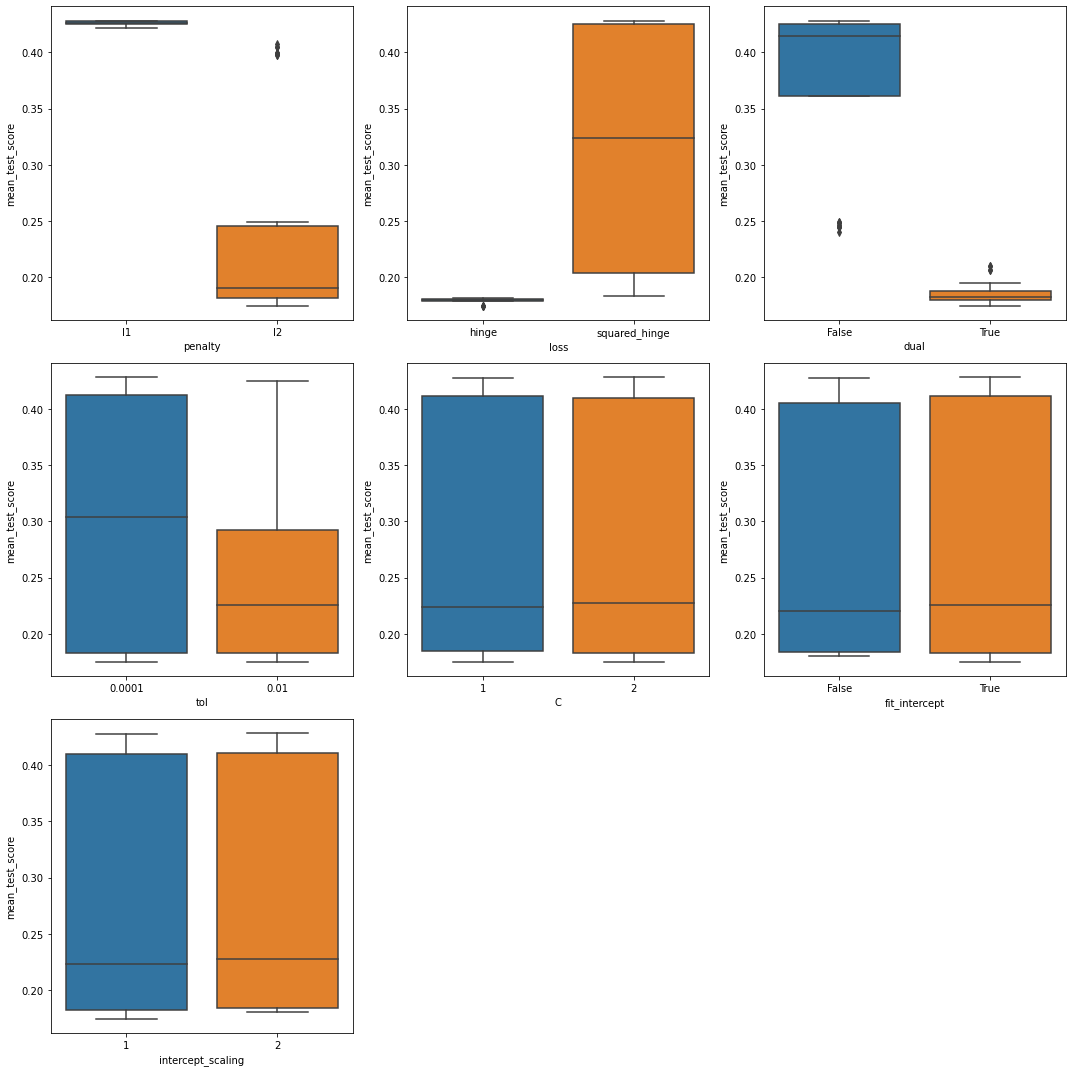

In [10]:
from sklearn.metrics import accuracy_score, confusion_matrix, mean_absolute_error, classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

def filter_df_column_by_list(df, column, values):
  # return df[df[column].str.contains('|'.join(values))]
  # return df[column].query('&'.join(values))
  return df[df[column].isin(values)]

def grid_to_df(grid):
  df = pd.DataFrame(grid.cv_results_)
  df = pd.concat([df, df['params'].apply(pd.Series)], axis=1)
  return df

def plot_parameters(grid, parameters):
  counter = 1
  columns = 3
  lines = len(parameters)//columns+1
  plt.rcParams['figure.figsize'] = (5*columns, 5*lines)
  df = grid_to_df(grid)
  for p in parameters.keys():
    v = parameters[p]
    df = filter_df_column_by_list(df, p, v)
  for p in parameters.keys():
    if len(parameters[p]) > 1:
      plt.subplot(lines, columns, counter) 
      sns.boxplot(x = df[p], y=df['mean_test_score'])
      counter += 1
  plt.tight_layout()
  plt.show()

def train_svm(xtrain, xtest, ytrain, ytest, parameters):
  SVM = LinearSVC(class_weight = 'balanced', random_state = 12, max_iter = 1500)
  grid = GridSearchCV(SVM, parameters)
  print(grid)
  grid.fit(xtrain, ytrain)
  print("Best model:", grid.best_params_)
  print("Score:", grid.score(xtest, ytest))
  return grid

# parameters_svm = {
#     'penalty' : ('l1', 'l2'),
#     'loss' : ('hinge', 'squared_hinge'),
#     'dual' : (True, False),
#     'tol' : [1e-2, 1e-4, 1e-6, 1e-8],
#     'C' : [1, 2, 4, 8],
#     'fit_intercept' : (True, False),
#     'intercept_scaling' : [1, 2, 4]
# }

parameters_svm = {
    'penalty' : ['l1', 'l2'],
    'loss' : ['hinge', 'squared_hinge'],
    'dual': [True, False],
    'tol' : [1e-2, 1e-4],
    'C' : [1, 2],
    'fit_intercept' : [True, False],
    'intercept_scaling' : [1, 2]
}

# parameters_svm = {
#     'penalty' : ['l1'],
#     'loss' : ['squared_hinge'],
#     'dual': [False],
#     'tol' : [1e-4],
#     'C' : [1],
#     'fit_intercept' : [True],
#     'intercept_scaling' : [2]
# }

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .7, test_size = .3, stratify=y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

grid_svm = train_svm(X_train, X_test, y_train, y_test, parameters_svm)
plot_parameters(grid_svm, parameters_svm)

In [12]:
parameters_svm_final = {
    'penalty' : ['l1'],
    'loss' : ['squared_hinge'],
    'dual': [False],
    'tol' : [1e-4],
    'C' : [1],
    'fit_intercept' : [True],
    'intercept_scaling' : [2]
}

grid_svm_final = train_svm(X_train, X_test, y_train, y_test, parameters_svm_final)
plot_parameters(grid_svm_final, parameters_svm_final)

GridSearchCV(estimator=LinearSVC(class_weight='balanced', max_iter=1500,
                                 random_state=12),
             param_grid={'C': [1], 'dual': [False], 'fit_intercept': [True],
                         'intercept_scaling': [2], 'loss': ['squared_hinge'],
                         'penalty': ['l1'], 'tol': [0.0001]})
Best model: {'C': 1, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 2, 'loss': 'squared_hinge', 'penalty': 'l1', 'tol': 0.0001}
Score: 0.4149976711690731


<Figure size 1080x1080 with 0 Axes>

In [17]:
from sklearn.metrics import classification_report
def estimate_error(grid, pred, y_test):
#   print("Score", grid.score(X_test, y_test))
  print("Accuracy score", accuracy_score(y_test, pred))
  print("Mean absolute error", mean_absolute_error(y_test, pred))
#   print(confusion_matrix(y_test, pred))
#   print(classification_report(y_test, pred))

predictions = grid_svm_final.predict(X_test)
for className in pd.unique(y):
    mask = [y_test == className]
    pred = predictions[mask]
    class_y_test = y_test[mask]
    print(lenc.inverse_transform([className]))
    estimate_error(grid_svm, pred, class_y_test)
    
target_names = lenc.inverse_transform(pd.unique(y))
print(classification_report(y_test, predictions, target_names=target_names))

report = classification_report(y_test, predictions, target_names=target_names, output_dict = True)
report_df = pd.DataFrame(report).transpose()
print(report_df.to_latex())

['celular']
Accuracy score 0.1625615763546798
Mean absolute error 3.8029556650246303
['sapato']
Accuracy score 0.2916666666666667
Mean absolute error 2.337962962962963
['chinelo']
Accuracy score 0.027777777777777776
Mean absolute error 2.8425925925925926
['caneca']
Accuracy score 0.4212962962962963
Mean absolute error 3.009259259259259
['tesoura']
Accuracy score 0.32407407407407407
Mean absolute error 3.837962962962963
['livro']
Accuracy score 0.4398148148148148
Mean absolute error 1.5
['portacopo']
Accuracy score 0.8101851851851852
Mean absolute error 0.7453703703703703
['garrafa']
Accuracy score 0.25925925925925924
Mean absolute error 2.0833333333333335
['prato']
Accuracy score 0.6990740740740741
Mean absolute error 0.8055555555555556
['chave']
Accuracy score 0.6990740740740741
Mean absolute error 1.3333333333333333
              precision    recall  f1-score   support

     celular       0.43      0.42      0.43       216
      sapato       0.37      0.16      0.23       203
     ch